In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import scipy.io as sio
from sklearn.model_selection import train_test_split
import os
import pickle
import pandas as pd
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
os.system('wget https://www.dropbox.com/s/7xwcebcsxj5ne9x/llantas.mat?dl=0')
os.system('mv llantas.mat?dl=0 llantas.mat')

0

### Datos

In [3]:
data=sio.loadmat('llantas.mat')
Images=data['images'][:600]
labels=data['labels'][0][:600]
Class =data['class']
sz=np.shape(Images)

0 flat   


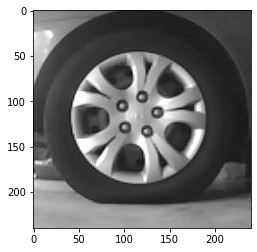

In [4]:
ind=np.random.choice(np.shape(Images)[0])
plt.imshow(Images[ind])
print(labels[ind], Class[labels[ind]])

In [5]:
print(Images.dtype)
print(np.min(Images), np.max(Images))
print(sz)
print(np.shape(labels))

float32
0.0 1.0
(600, 240, 240, 3)
(600,)


### Preprocesamiento y análisis dimensional

In [6]:
#Aplanar datos y tomar un solo canal
images=Images[...,0].reshape((sz[0],sz[1]*sz[2]))
print(np.shape(images))

(600, 57600)


In [7]:
from sklearn.decomposition import PCA

In [8]:
pca = PCA()
pca.fit(images)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Numero mínimo de componentes para el 99% :  441


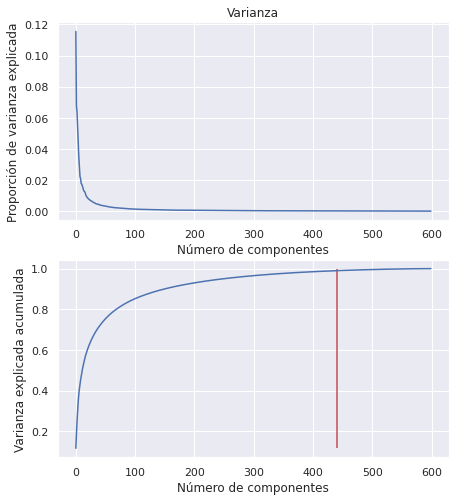

In [9]:
sns.set_theme()
plt.figure(figsize=(7,8))
plt.subplot(2,1,1)
plt.plot(pca.explained_variance_ratio_)
plt.title('Varianza')
plt.ylabel('Proporción de varianza explicada')
plt.xlabel('Número de componentes')
plt.subplot(2,1,2)
sum=np.sum(np.cumsum(pca.explained_variance_ratio_)<0.99)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.vlines(sum, np.min(np.cumsum(pca.explained_variance_ratio_)), 1, 'r')
plt.ylabel('Varianza explicada acumulada')
plt.xlabel('Número de componentes')
print('Numero mínimo de componentes para el 99% : ', sum)
plt.savefig('Varinza explicada.svg')

In [10]:
Pca = PCA(n_components=441)
Pca.fit(images)
imagesx=Pca.transform(images)
print(np.shape(imagesx))

(600, 441)


In [11]:
#Dividir en datos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(imagesx, labels, test_size=0.30)

print('Entrenamiento :', x_train.shape, y_train.shape)
print('Prueba        :', x_test.shape, y_test.shape)

Entrenamiento : (420, 441) (420,)
Prueba        : (180, 441) (180,)


# Entrenamiento de los modelos

In [12]:
df=pd.DataFrame(columns=('Model', 'acc_train', 'acc_test'))

In [13]:
def training(model, x, y, xt, yt, name, df):
  model.fit(x,y)                                        #Entrenar modelo
  y_hat=model.predict(xt)                               #predecir resultados
  acc=np.mean(y_hat==yt)                                #validar precisión
  y_hat=model.predict(x)                                #predecir resultados
  acx=np.mean(y_hat==y)                                 #validar precisión
  pickle.dump(model, open(name+'.sav', 'wb'))           #Guardar modelo
  print('Accuracy :', acc)
  df=df.append({'Model': name , 'acc_train': acx, 'acc_test': acc}, ignore_index=True)
  df=df.drop(df.columns[:np.where(df.columns=='Model')[0][0]], axis=1)
  return df

### Maquina de soporte vectorial (SVM)

In [14]:
model1=svm.SVC(probability=True)                        
df=training(model1, x_train, y_train, x_test, y_test, 'SVM', df)

Accuracy : 0.9944444444444445


In [15]:
model2=svm.SVC(kernel='linear', probability=True)                          
df=training(model2, x_train, y_train, x_test, y_test, 'SVM_Kernel_linear', df)

Accuracy : 0.9888888888888889


### Red feed forward

In [16]:
model3=MLPClassifier(hidden_layer_sizes=(100,50,24))
df=training(model3, x_train, y_train, x_test, y_test, 'MLP_3layers', df)

Accuracy : 0.9333333333333333


In [17]:
model4=MLPClassifier(hidden_layer_sizes=(75,24))
df=training(model4, x_train, y_train, x_test, y_test, 'MLP_2layers', df)

Accuracy : 0.8944444444444445


### Bosque aleatorio combinado

In [19]:
#Matriz de datos de los algoritmos combinados
x1=model1.predict_proba(imagesx)[:,0].reshape((np.shape(imagesx)[0],1))
x2=model2.predict_proba(imagesx)[:,0].reshape((np.shape(imagesx)[0],1))
x3=model3.predict_proba(imagesx)[:,0].reshape((np.shape(imagesx)[0],1))
x4=model4.predict_proba(imagesx)[:,0].reshape((np.shape(imagesx)[0],1))

In [20]:
x_data=np.concatenate((x1,x2,x3,x4), axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(x_data, labels, test_size=0.30)

print('Entrenamiento :', xtrain.shape, ytrain.shape)
print('Prueba        :', xtest.shape, ytest.shape)

Entrenamiento : (420, 4) (420,)
Prueba        : (180, 4) (180,)


In [21]:
model5=RandomForestClassifier()
df=training(model5, xtrain, ytrain, xtest, ytest, 'RandomForest', df)

Accuracy : 1.0


# Resultados

In [23]:
df

,Model,acc_train,acc_test
0,SVM,1.0,0.994444
1,SVM_Kernel_linear,1.0,0.988889
2,MLP_3layers,1.0,0.933333
3,MLP_2layers,1.0,0.894444
4,RandomForest,1.0,1.000000
